Distributions
============================

Distributions are mostly useful when using samplers (which we'll see in the next tutorial on [solving the inverse problem](./solver.ipynb)) - but can also be useful to propagate any set of distributions (whether those be uncertainties in the literature, etc) through the forward model.

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

In [2]:
import phoebe

logger = phoebe.logger()

b = phoebe.default_binary()
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))

<ParameterSet: 78 parameters | contexts: dataset, figure, compute, constraint>

Adding Distributions
----------------------

Distributions can be attached to most any FloatParameter in the Bundle.  To see a list of these available parameters, we can call [b.get_adjustable_parameters](../api/phoebe.frontend.bundle.Bundle.get_adjustable_parameters.md).  Note the `exclude_constrained` option which defaults to True: we can set distributions on constrained parameters (for priors, for example), but those will not be able to be sampled from in the forward model or while fitting.  We'll come back to this in the next tutorial when looking at priors.


In [3]:
b.get_adjustable_parameters()

<ParameterSet: 35 parameters | contexts: component, dataset, system>

[add_distribution](../api/phoebe.frontend.bundle.Bundle.add_distribution.md) is quite flexible and accepts several different syntaxes to add multiple distributions in one line.  Here we'll just attach a distribution to a single parameter at a time.  Just like when calling [add_dataset](../api/phoebe.frontend.bundle.Bundle.add_dataset.md) or [add_compute](../api/phoebe.frontend.bundle.Bundle.add_compute.md), [add_distribution](../api/phoebe.frontend.bundle.Bundle.add_distribution.md) optionally takes a `distribution` tag -- and in the cases of distributions, we can attach distributions to multiple parameters with the same `distribution` tag.

The values of the [DistributionParameters](../api/phoebe.parameters.DistributionParameter.md) are [distl](https://distl.readthedocs.io) distribution objects -- the most common of which are conveniently available at the top-level of PHOEBE:

* [phoebe.gaussian](../api/phoebe.gaussian.md)
* [phoebe.gaussian_around](../api/phoebe.gaussian_around.md)
* [phoebe.uniform](../api/phoebe.uniform.md)
* [phoebe.uniform_around](../api/phoebe.uniform_around.md)

For an overview of the different available types as they apply in PHOEBE, see [Advanced: Distribution Types](distribution_types.ipynb).

Now let's attach a gaussian distribution on the temperature of the primary star.

In [4]:
b.add_distribution(qualifier='teff', component='primary', 
                   value=phoebe.gaussian(6000,100), 
                   distribution='mydist')

<ParameterSet: 1 parameters>

As you probably can expect by now, we also have methods to:

* [get_distribution](../api/phoebe.frontend.bundle.Bundle.get_distribution.md)
* [rename_distribution](../api/phoebe.frontend.bundle.Bundle.rename_distribution.md)
* [remove_distribution](../api/phoebe.frontend.bundle.Bundle.remove_distribution.md)

In [5]:
print(b.get_distribution(distribution='mydist'))

ParameterSet: 1 parameters
         teff@mydist@distribution: <distl.gaussian loc=6000.0 scale=100.0 unit=K>


Now let's add another distribution, with the same `distribution` tag, to the inclination of the binary.

In [6]:
b.add_distribution(qualifier='incl', component='binary',
                   value=phoebe.uniform(80,90),
                   distribution='mydist')

<ParameterSet: 1 parameters>

In [7]:
print(b.get_distribution(distribution='mydist'))

ParameterSet: 2 parameters
         teff@mydist@distribution: <distl.gaussian loc=6000.0 scale=100.0 unit=K>
         incl@mydist@distribution: <distl.uniform low=80.0 high=90.0 unit=deg>


Accessing & Plotting Distributions
--------------------

The parameters we've created and attached are [DistributionParameters](../api/phoebe.parameters.DistributionParameter.md) and live in `context='distribution'`, with all other tags matching the parameter they're referencing.  For example, let's filter and look at the distributions we've added.

In [8]:
print(b.filter(context='distribution'))

ParameterSet: 2 parameters
         teff@mydist@distribution: <distl.gaussian loc=6000.0 scale=100.0 unit=K>
         incl@mydist@distribution: <distl.uniform low=80.0 high=90.0 unit=deg>


In [9]:
print(b.get_parameter(context='distribution', qualifier='incl'))

Parameter: incl@mydist@distribution
                       Qualifier: incl
                     Description: distribution for the referenced parameter
                           Value: <distl.uniform low=80.0 high=90.0 unit=deg>
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [10]:
print(b.get_parameter(context='distribution', qualifier='incl').tags)

OrderedDict([('time', None), ('qualifier', 'incl'), ('feature', None), ('component', 'binary'), ('dataset', None), ('constraint', None), ('distribution', 'mydist'), ('compute', None), ('model', None), ('solver', None), ('solution', None), ('figure', None), ('kind', None), ('context', 'distribution')])


The "value" of the parameter, is the [distl](https://distl.readthedocs.io) distributon object itself.

In [11]:
b.get_value(context='distribution', qualifier='incl')

<distl.uniform low=80.0 high=90.0 unit=deg>

And because of that, we can call any method on the [distl](https://distl.readthedocs.io) object, including plotting the distribution.

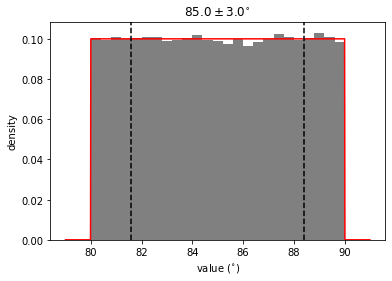

In [12]:
_ = b.get_value(context='distribution', qualifier='incl').plot(show=True)

If we want to see how multiple individual distributions interact and are correlated with each other via a corner plot, we can access the combined "distribution collection" from any number of `distribution` tags. This may not be terribly useful now, but is very useful when trying to create multivariate priors.

* [b.get_distribution_collection](../api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md)
* [b.plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md)

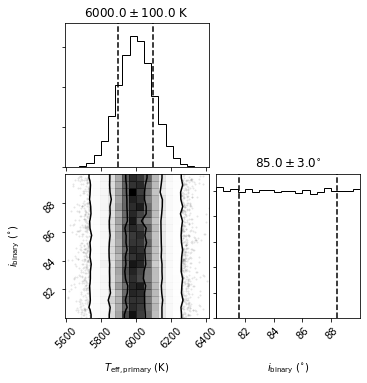

In [13]:
_ = b.plot_distribution_collection(distribution='mydist', show=True)

Sampling Distributions
-------------------

We can also sample from these distributions - either manually by calling sample on the [distl](https://distl.readthedocs.io) or in bulk by respecting any covariances in the "distributon collection" via:

* [b.sample_distribution_collection](../api/phoebe.frontend.bundle.Bundle.sample_distribution_collection.md)

In [14]:
b.sample_distribution_collection(distribution='mydist')

{'teff@primary@star@component': 5868.749841594311,
 'incl@binary@orbit@component': 84.46696942047119}

By default this just returns a dictionary with the twigs and sampled values.  But if we wanted, we could have these applied immediately to the face-values by passing `set_value=True`, in which case a [ParameterSet](../api/phoebe.parameters.ParameterSet.md) of changed parameters (including those via constraints) is returned instead.

In [15]:
changed_params = b.sample_distribution_collection(distribution='mydist', set_value=True)

In [16]:
print(changed_params)

ParameterSet: 11 parameters
           teff@primary@component: 5892.109685011345 K
            incl@binary@component: 81.11158020909615 deg
C          asini@binary@component: 5.236352907041227 solRad
C         asini@primary@component: 2.6181764535206136 solRad
C          incl@primary@component: 81.11158020909615 deg
C    requiv_max@primary@component: 2.013275176537638 solRad
C       asini@secondary@component: 2.6181764535206136 solRad
C        incl@secondary@component: 81.11158020909615 deg
C  requiv_max@secondary@component: 2.013275176537638 solRad
C    requiv_max@primary@component: 2.013275176537638 solRad
C  requiv_max@secondary@component: 2.013275176537638 solRad


Propagating Distributions through Forward Model
-------------------

Lastly, we can have PHOEBE automatically draw from a "distribution collection" multiple times and expose the distribution of the model itself.

In [17]:
print(b.get_parameter(qualifier='sample_from', context='compute'))

Parameter: sample_from@phoebe01@compute
                       Qualifier: sample_from
                     Description: distributions or solutions to use for sampling.  If pointing to a solution, adopt_solution(as_distributions=True, **kwargs) will be called to create a temporary distribution which will be removed automatically.  If all distributions are delta functions (face-values), sample_mode and sample_num will be ignored with a warning.
                           Value: []
                         Choices: mydist
                  Constrained by: 
                      Constrains: None
                      Related to: None



Once `sample_from` is set, `sample_num` and `sample_mode` are exposed as visible parameters

In [18]:
b.set_value('sample_from', value='mydist')

In [19]:
print(b.filter(qualifier='sample*'))

ParameterSet: 4 parameters
     sample_from@phoebe01@compute: ['mydist']
   sample_from_combine@phoebe0...: first
      sample_num@phoebe01@compute: 10
     sample_mode@phoebe01@compute: 1-sigma


Now when we call [run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md), 10 different instances of the forward model will be computed from 10 random draws from the "distribution collection" but only the median and 1-sigma uncertainties will be exposed in the model.

In [20]:
b.run_compute(irrad_method='none')

100%|██████████| 101/101 [00:10<00:00,  9.95it/s]


<ParameterSet: 8 parameters | qualifiers: sampled_twigs, comments, samples, failed_samples, sampled_uniqueids, times, fluxes, sample_mode>

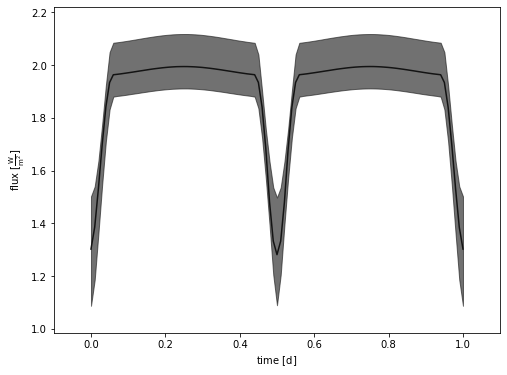

In [21]:
_ = b.plot(show=True)

Next
----------

Next up: let's learn about [solving the inverse problem](./solver.ipynb)

Or more about these advanced distributions topics:
* [Advanced: Distribution Types](./distribution_types.ipynb)
* [Advanced: Latex Representation](./latex_repr.ipynb)
